In [56]:
import os
import pandas as pd
import numpy as np
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn import plotting
from glob import glob

Set paths and load the behavioral data for n = 1

In [139]:
dir_in = '/Users/michaeldemidenko/Downloads/2YearFollowUpYArm1_MID'
dir_out = '/Users/michaeldemidenko/Downloads'
beh_n1 = glob(f'{dir_in}/*_task-MID_run-01_events.tsv')[0]

In [69]:
events_df = pd.read_csv(beh_n1,sep='\t')
events_df.columns

Index(['Subject', 'Handedness', 'Run', 'SubTrial', 'Condition',
       'Cue.OnsetTime', 'Cue.Duration', 'Anticipation.Duration',
       'Anticipation.OnsetTime', 'Probe.Duration', 'Probe.OnsetTime',
       'Probe.RESP', 'Result', 'prbacc', 'prbrt', 'OverallRT', 'meanrt',
       'moneyamt', 'ResponseCheck', 'Feedback.OnsetTime', 'FeedbackDuration',
       'SessionDate', 'TriggerTime', 'TriggerTimeAlt', 'DiffTriggerTimes'],
      dtype='object')

In [153]:
events_df[['Probe.Duration', 'Probe.OnsetTime','OverallRT']]

,Probe.Duration,Probe.OnsetTime,OverallRT
0,0.326,6.00,263.0
1,0.326,13.51,257.0
2,0.326,19.52,219.0
3,0.326,25.03,201.0
4,0.276,33.04,268.0
5,0.276,38.55,281.0
6,0.276,46.06,213.0
7,0.276,51.57,208.0
8,0.246,57.08,NaN
9,0.246,63.59,191.0


Question...

ABCD - 
Reward Hit - Reward Miss ($5/0.20)
Reward Hit - Neutral hit 

If RT effect - adjust
If contrast for feedback --> decreases effect = okay?

In [154]:
events_df[['Feedback.Response','OverallRT']].groupby('Feedback.Response').mean('OverallRT')

,OverallRT
Feedback.Response,
LgPun_hit,223.375000
LgPun_miss,258.000000
LgReward_hit,217.800000
LgReward_miss,255.333333
SmallPun_hit,215.000000
SmallPun_miss,262.000000
SmallReward_hit,235.800000
SmallReward_miss,234.250000
Triangle_hit,225.428571


Create a more consistent hit/miss Feedback column based on probe accuracy

In [70]:
events_df['Feedback.Response'] = np.where(events_df['prbacc'] == 1.0,
                                          events_df['Condition'] + '_hit',
                                          events_df['Condition'] + '_miss')


Create stacked conditions, onsets and durations to be used in first level. 

In order of phases modeled:

Anticipation:
1. Condition
2. Cue.OnsetTime
3. Cue.Duration

Feedback:
1. Feedback.Response
2. Feedback.OnsetTime
3. Feedback.Duration

Two probe regressor:

Probe - Regressor 1: Probe.OnsetTime + Probe.duration

Prone_rt - Regressor 2: Probe.OnsetTime + OverallRT / 1000

Probe:
1. Constant probe cue
2. Probe.OnsetTime
3. Probe.Duration

Probe_rt:
1. Constant probe_rt label -- omit rows w/o response
2. Probe.OnsetTime -- omit rows w/o response
3. OverallRT -- duration is the RT time, omit rows w/o response (ms --> sec)



In [146]:
conditions = pd.concat([events_df.loc[:, "Condition"], 
                        events_df.loc[:, "Feedback.Response"],
                        pd.Series(["probe"] * len(events_df[['OverallRT','Probe.OnsetTime']])),
                        pd.Series(["probe_rt"] * len(events_df[['OverallRT','Probe.OnsetTime']].dropna()))
                       ], ignore_index=True)
onsets = pd.concat([events_df.loc[:, 'Cue.OnsetTime'], 
                    events_df.loc[:, "Feedback.OnsetTime"],
                    events_df.loc[:, "Probe.OnsetTime"],
                    events_df[['OverallRT','Probe.OnsetTime']].dropna()['Probe.OnsetTime']
                   ], ignore_index=True)
duration = pd.concat([events_df.loc[:, 'Cue.Duration'], 
                      events_df.loc[:, "FeedbackDuration"],
                      events_df.loc[:, "Probe.Duration"],
                      (events_df[['OverallRT','Probe.OnsetTime']].dropna()['OverallRT'])/1000
                     ], ignore_index=True)

# create pandas df with events
design_events = pd.DataFrame({
    'trial_type': conditions,
    'onset': onsets,
    'duration': duration
})

In [147]:
design_events

,trial_type,onset,duration
0,Triangle,2.02,2.000
1,SmallReward,8.04,2.000
2,LgPun,15.55,2.000
3,SmallReward,21.57,2.000
4,LgReward,27.07,2.000
...,...,...,...
188,probe_rt,281.44,0.235
189,probe_rt,289.45,0.211
190,probe_rt,296.96,0.217
191,probe_rt,303.97,0.301


Create nilean design matrix for n volumes + bold TR in MID ABCD w/o stc and spm model.
Subsequent versions will include dift models calculated by fmriprep + x,y,z + derivatives motion regressors

In [148]:
# vols / tr
num_volumes = 403
bold_tr = .800

# Using the BOLD tr and volumes to generate the frame_times: acquisition time in seconds
frame_times = np.arange(num_volumes) * bold_tr

design_matrix_mid = make_first_level_design_matrix(
    frame_times=frame_times,
    events=design_events,
    hrf_model='spm', drift_model=None, add_regs=None
    )

In [149]:
reorder_cols = ['constrant',
                'LgReward', 'SmallReward', 'Triangle', 'SmallPun', 'LgPun',
                'LgReward_hit', 'LgReward_miss', 'SmallReward_hit', 'SmallReward_miss',
                'Triangle_hit', 'Triangle_miss', 'SmallPun_hit', 'SmallPun_miss',
                'LgPun_hit', 'LgPun_miss', 'probe','probe_rt']
design_matrix_mid = design_matrix_mid.reindex(columns=reorder_cols)
print("Size of design matrix minus intercept:", design_matrix_mid.shape[-1]-1)

Size of design matrix minus intercept: 17


<AxesSubplot:label='conditions', ylabel='scan number'>

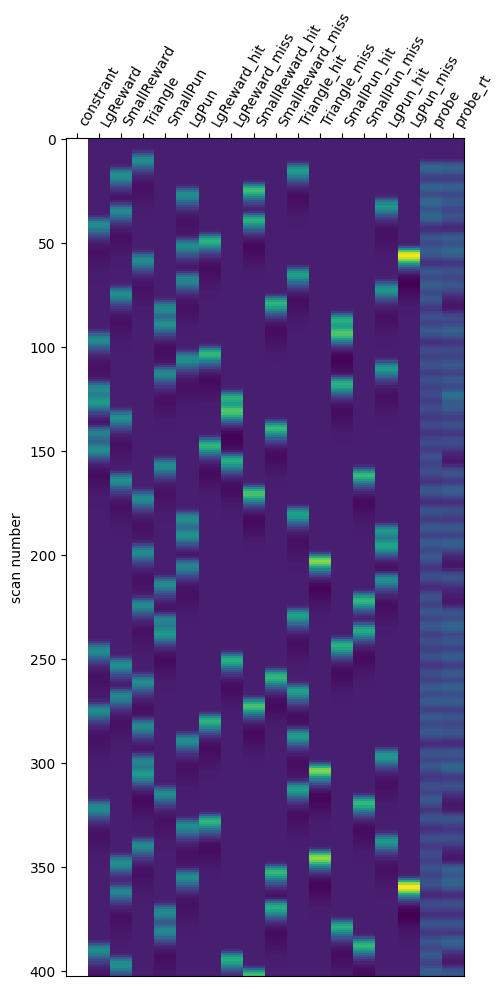

In [156]:
design_events.to_csv(f'{dir_out}/design_events_df.csv', index=False)
plotting.plot_design_matrix(design_matrix_mid)